# JuliaでIzhikevichモデル
> 
- toc: true 
- badges: true
- comments: true
- categories: [neuroscience]
- author: 山拓

Juliaで[Izhikevichモデル](https://www.izhikevich.org/publications/spikes.htm)の実装をする。JuliaによるSNNの実装は[SpikingNeuralNetworks.jl](https://github.com/AStupidBear/SpikingNeuralNetworks.jl)が既にある。この記事の実装ではJuliaの書き方を勉強すべく大幅に参考にした。以下はJulia 1.4.0で実行。ブログでは何故かJuliaのSyntax highlightがされてない。

## モデルの定義
まず必要なパッケージを読み込む。[Parameters.jl](https://github.com/mauro3/Parameters.jl)は`struct`のデフォルト値の設定のために必要。`struct`の前に`@with_kw`というmacroを書くことで`struct`をデコレートできる。ただ、この記事を書いた後に@bicycle1885氏に以下のように教えていただいたので、`Base.@kwdef`を用いることにした。感謝…！

> twitter: https://twitter.com/bicycle1885/status/1283067236043812865

In [1]:
#using Parameters
using UnPack
using Plots

変更しない定数を保持する`struct`の`IZParameter`と、変数を保持する`mutable struct`の`IZ`を作成する。

In [2]:
Base.@kwdef struct IZParameter
    a::Float32 = 0.02
    b::Float32 = 0.2
    c::Float32 = -65
    d::Float32 = 8.0
    vrest::Float32 = -60.0
    vpeak::Float32 = 30.0
end

Base.@kwdef mutable struct IZ
    param::IZParameter = IZParameter()
    N::Int32
    v::Vector{Float32} = fill(param.vrest, N)
    u::Vector{Float32} = param.b * v 
    fire::Vector{Bool} = zeros(Bool, N)
end

IZ

## 変数の更新式 (forループを使う場合)
次に変数を更新する関数`updateIZ!`を書く。関数名に`!`を付けるのは、引数を関数の中で変更する場合は関数名に`!`記号を付けるというJuliaの習慣らしい。
- [julia - What does exclamation mark means after the name of functions? - Stack Overflow](https://stackoverflow.com/questions/45396685/what-does-exclamation-mark-means-after-the-name-of-functions)
- [Style Guide · The Julia Language](https://docs.julialang.org/en/latest/manual/style-guide/#Append-!-to-names-of-functions-that-modify-their-arguments-1)

In [3]:
function updateIZ!(variable::IZ, param::IZParameter, I::Vector{Float32}, dt::Float32)
    @unpack N, v, u, fire = variable
    @unpack a, b, c, d, vrest, vpeak = param
    @inbounds for i = 1:N
        v[i] += dt * (0.04f0v[i]^2 + 5f0v[i] + 140f0 - u[i] + I[i])
        u[i] += dt * (a * (b * v[i] - u[i]))
    end
    @inbounds for i = 1:N
        fire[i] = v[i] >= vpeak
        v[i] = ifelse(fire[i], c, v[i])
        u[i] += ifelse(fire[i], d, 0)
    end
end

updateIZ! (generic function with 1 method)

`for`ループを用いて1つのニューロンごとに膜電位`v`や回復変数`u`を更新する。SNN本ではPythonを使ったので後述するベクトル表記を使用したが、Juliaなら問題なし。macro `@inbounds`を使うと配列の境界確認が無くなり高速化されるらしい ([Bounds checking · The Julia Language](https://docs.julialang.org/en/v1/devdocs/boundscheck/))。

## シミュレーションの実行
いくつかの定数を設定してシミュレーションを実行する。恐らくもっと早い書き方があると思うのですが… (forループを関数内で書いた方が速いという話は聞いているが以下ではべた書きしている)。

In [4]:
const T = 400 # ms
const dt = 0.01f0 # ms
const nt = Int32(T/dt) # number of timesteps
const N = 100 # ニューロンの数

# 入力刺激
t = Array{Float32}(1:nt)*dt
I = repeat(10f0 * ((t .> 50) - (t .> 350)), 1, N)  # injection current

# 記録用
varr = zeros(Float32, nt, N)
uarr = zeros(Float32, nt, N)

# modelの定義
neurons = IZ(N=N)

# simulation
@time for i = 1:nt
    updateIZ!(neurons, neurons.param, I[i, :], dt)
    varr[i, :] = neurons.v
    uarr[i, :] = neurons.u
end

  0.350754 seconds (742.80 k allocations: 36.762 MiB)


結果の描画。シミュレーションは100個のニューロンで行ったが、とりあえず1つのニューロンの膜電位`v`、回復変数`u`、刺激電流`I`の描画。

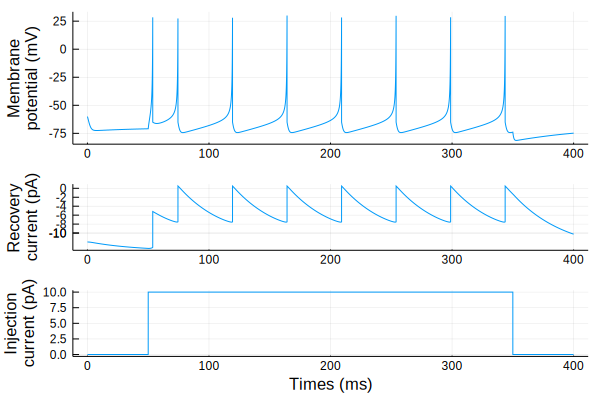

In [5]:
p1 = plot(t, varr[:, 1])
p2 = plot(t, uarr[:, 1])
p3 = plot(t, I[:, 1])
plot(p1, p2, p3, 
    xlabel = ["" "" "Times (ms)"], 
    ylabel= ["Membrane\n potential (mV)" "Recovery\n current (pA)" "Injection\n current (pA)"],
    layout = grid(3, 1, heights=[0.5, 0.25, 0.25]), legend = false)

## 変数の更新式 (ベクトルを使う場合)

更新式をベクトルで表現する。

In [6]:
function update_vecIZ!(variable::IZ, param::IZParameter, I::Vector{Float32}, dt::Float32)
    @unpack N, v, u, fire = variable
    @unpack a, b, c, d, vrest, vpeak = param

    v[:] += dt * (0.04f0v.^2 + 5f0v .+ 140f0 - u + I)
    u[:] += dt * (a * (b * v - u))
    
    fire = v .>= vpeak
    u[:] += d * fire
    v[:] = v .* (1 .- fire) + c * fire
end

update_vecIZ! (generic function with 1 method)

なお、上の関数において`v[:] += ...`ではなく`v += ...`としていたために変数の更新が行われず嵌った。[Mutating function in Julia (function that modifies its arguments) - Stack Overflow](https://stackoverflow.com/questions/39293082/mutating-function-in-julia-function-that-modifies-its-arguments)
によると

```julia
function right1_fill_with_twos!(v::Vector{Int64})
    v[:]=[2 for ii in 1:length(v)]
end
```

は機能して

```julia
function wrong1_fill_with_twos!(v::Vector{Int64})
    v=[2 for ii in 1:length(v)]
end
```

はダメらしい。

同様にシミュレーションを実行。Pythonと異なり、forループを用いた更新の方が速い。

In [7]:
# 記録用
varr2 = zeros(Float32, nt, N)
uarr2 = zeros(Float32, nt, N)

neurons = IZ(N=N)

@time for i = 1:nt
    update_vecIZ!(neurons, neurons.param, I[i, :], dt)
    varr2[i, :] = neurons.v
    uarr2[i, :] = neurons.u
end

  0.425835 seconds (1.52 M allocations: 448.538 MiB, 13.61% gc time)


結果を表示する。

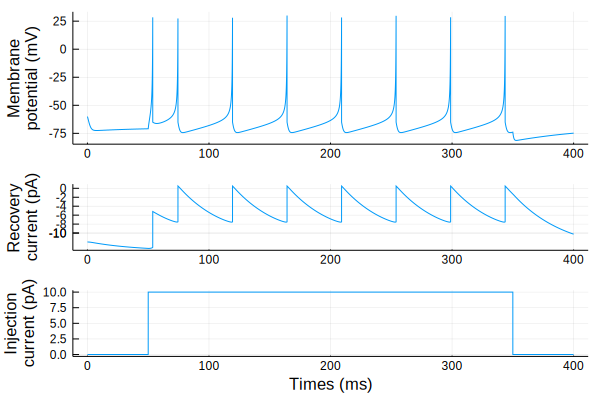

In [8]:
p1 = plot(t, varr2[:, 1])
p2 = plot(t, uarr2[:, 1])
p3 = plot(t, I[:, 1])
plot(p1, p2, p3, 
    xlabel = ["" "" "Times (ms)"], 
    ylabel= ["Membrane\n potential (mV)" "Recovery\n current (pA)" "Injection\n current (pA)"],
    layout = grid(3, 1, heights=[0.5, 0.25, 0.25]), legend = false)

## 記事を書いた動機
『Juliaで学ぶ計算論的神経科学』的な本を2～5年後ぐらいに何らかの形式で出したいと思っています。とりあえずSNN本([ゼロから作るSpiking Neural Networks](https://yamtak.booth.pm/items/1585421))のJulia版をJupyter Notebook形式で公開して既存の内容についてコメントを貰いたいと思っています。Juliaに強い方、この記事のコードでもっと良い書き方があればお教えいただきたく存じます。

> twitter: https://twitter.com/tak_yamm/status/1272869498740043776